In [1]:
import pymysql
import pandas as pd
import re
from bs4 import BeautifulSoup
from hanziconv import HanziConv
from zhon import hanzi
import string
punctuation=hanzi.punctuation + string.punctuation
punctuation = set([i for i in punctuation])
import html
conn = pymysql.connect(host='127.0.0.1',port=3306,user='root',password='eXYhzAWjyvy8grwM',db='game_process',charset='utf8mb4')
sql = "SELECT id,source,game_name, user_name,comment_time,content, score,type FROM s_lcs_game_comments_qq WHERE type=2 or type=3"
df_comment = pd.read_sql(sql, conn)  # 返回的是 dataFrame 数据结构
df_comment['type'] = df_comment['type'] - 2
conn.close()
df_comment.head()

,id,source,game_name,user_name,comment_time,content,score,type
0,1,qq_mobile,&nbsp;杀神免费版,游客,1381762690,修复手机卡进行道具付费的漏洞！功能实用。速度很快。,5,1
1,2,qq_mobile,&nbsp;杀神免费版,游客,1382515674,不错，不错这个游戏非常好玩随然登陆时间比较长但非常好玩的我看了一下登陆时间也差不多是一两分钟...,5,1
2,3,qq_mobile,&nbsp;杀神免费版,游客,1390121576,新区，推荐。我叫一杯凉茶。一起玩,5,0
3,4,qq_mobile,&nbsp;杀神免费版,游客,1403781770,请问通过人物，能不能找到账号和所在区。,5,0
4,5,qq_mobile,&nbsp;杀神免费版,游客,1404561529,经常卡死。经常卡死。经常卡死。经常卡死。响应很慢。响应很慢。响应很慢。响应很慢。响应很慢。响...,1,1


In [2]:
# type 2 无用评论，3 普通评论 
# 统计分析，两个类别的样本分布均匀
df_comment.groupby('type').count()

,id,source,game_name,user_name,comment_time,content,score
type,,,,,,,
0,402,402,402,402,402,402,402
1,742,742,742,742,742,742,742


In [3]:
def extract_text(x):
    soup = BeautifulSoup(x, 'html.parser')
    return soup.text

def clear_text_punctuation(x):
    x = html.unescape(x)  # 反转义字符,显示真实内容。
    x = HanziConv.toSimplified(x) # 汉字繁体 转成 简体
    x = x.strip() # 去除字符首尾的指定字符
    x = "".join([i for i in x if i not in punctuation]) # 遍历评论每个字符，若是标点，去掉用空字符连接
    return re.sub(r'\s+', ' ', x) # 把x通过正则表达式 (\s 代表空格，+ 代表多个)，替换成空字符   
# 数字和字母过滤方法，及一些特殊符号

In [4]:
df_comment['clear_content'] = df_comment['content'].apply(clear_text_punctuation)
df_comment.head(1)

,id,source,game_name,user_name,comment_time,content,score,type,clear_content
0,1,qq_mobile,&nbsp;杀神免费版,游客,1381762690,修复手机卡进行道具付费的漏洞！功能实用。速度很快。,5,1,修复手机卡进行道具付费的漏洞功能实用速度很快


In [5]:
import jieba
def jieba_word(x):
    word_list = [i for i in jieba.cut(x)]
    return ' '.join(word_list)

In [6]:
jieba_word('我想去吃饭')

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.749 seconds.
Prefix dict has been built succesfully.


'我 想 去 吃饭'

In [7]:
df_comment['jieba_word'] = df_comment['clear_content'].apply(jieba_word)
df_comment.head(1)

,id,source,game_name,user_name,comment_time,content,score,type,clear_content,jieba_word
0,1,qq_mobile,&nbsp;杀神免费版,游客,1381762690,修复手机卡进行道具付费的漏洞！功能实用。速度很快。,5,1,修复手机卡进行道具付费的漏洞功能实用速度很快,修复 手机卡 进行 道具 付费 的 漏洞 功能 实用 速度 很快


In [8]:
# # 构成词典 
# from gensim import corpora
# words = [x for x in df_comment['jieba_word']]
# dic = corpora.Dictionary(words)

# # 字数 14086， 感觉一千条评论不够，该手动分类一万条
# # 参考技术文章是 手动分类了一万条推特 twitter 的评论
# all_words = [y for x in words for y in x]
# print('%s words total, with a vocabulary size of %s ' % (len(all_words), len(dic)))

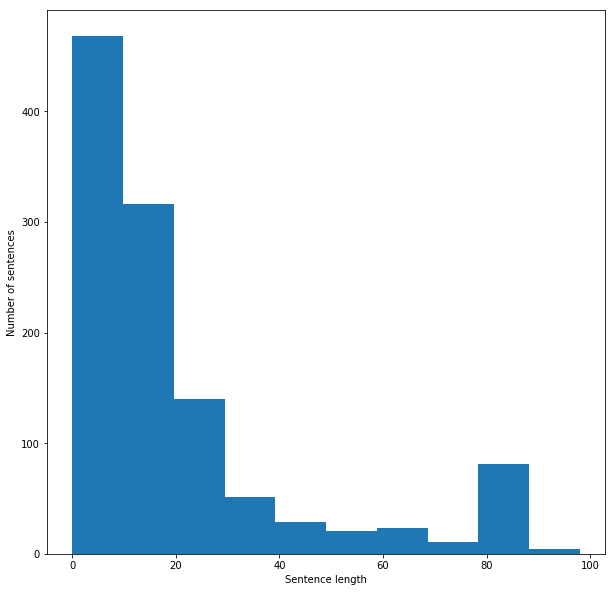

In [9]:
import matplotlib.pyplot as plt
sentence_lengths = [len(x) for x in df_comment['clear_content']]

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def cv(data):
    count_vectorizer = CountVectorizer()
    # emb 是词频矩阵呀,感觉和gensim 一样的效果
    # fit_transform 先获取词汇词典，返回词汇矩阵
    # transforn 返回词汇矩阵， 获取词典是以空格切分
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

list_corpus = df_comment["jieba_word"].tolist()
list_labels = df_comment["type"].tolist()
# X_test  len = len(list_corpus) * test_size 
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [11]:
# for x,y in count_vectorizer.vocabulary_.items():
#     print(x,y)
X_train_counts.shape

(915, 1511)

In [12]:
# # data1 = [' is good content', 'lcss is bad good ']
# data1 = ['修复手机卡进行道具付费的漏洞！功能实用。速度很快。', '功能实用。速度很快']
# lcs = CountVectorizer()
# # emb 是词频矩阵呀,感觉和gensim 一样的效果
# # fit_transform 先获取词汇词典，返回词汇矩阵
# # transforn 返回词汇矩阵
# lcs1 = lcs.fit_transform(data1)
# for x,y in lcs.vocabulary_.items():
#     print(x,y)

min x:-2.60536287909e-14, max x:6.98990174997
min y:-0.119308756709, max y:32.4880010439


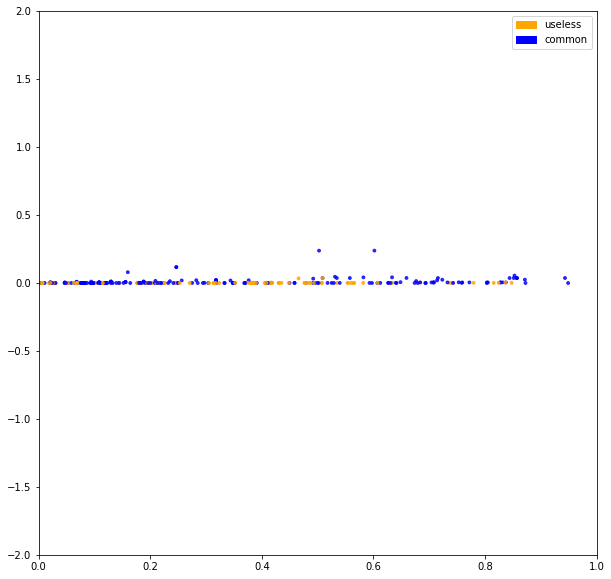

In [13]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
import math
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        # PCA 降维
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        # 查看数据降维效果
        #print(lsa_scores[1:100,:]) 
        print('min x:%s, max x:%s' % (min(lsa_scores[:,0]),max(lsa_scores[:,0])))
        print('min y:%s, max y:%s' % (min(lsa_scores[:,1]),max(lsa_scores[:,1])))   
        # type 2 useless, 3 common  结果 color_mapper={2:0, 3:1}
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0]*math.pow(10,2), lsa_scores[:,1]*math.pow(10,0), s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='useless')
            green_patch = mpatches.Patch(color='blue', label='common')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 10})
# 怎样才能让 数据点 出现在屏幕上
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train)
# 调节图像x,y 的大小，自己根据x y 轴慢慢调节
plt.axis([0,1,-2,2]) 
plt.show()

In [14]:
from sklearn.linear_model import LogisticRegression
# 逻辑回归 分类器
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)
y_predicted_counts

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1])

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.886, precision = 0.888, recall = 0.886, f1 = 0.887


In [16]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
# 检验模型情况，是漏判，还是误判严重
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=30)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)

    return plt

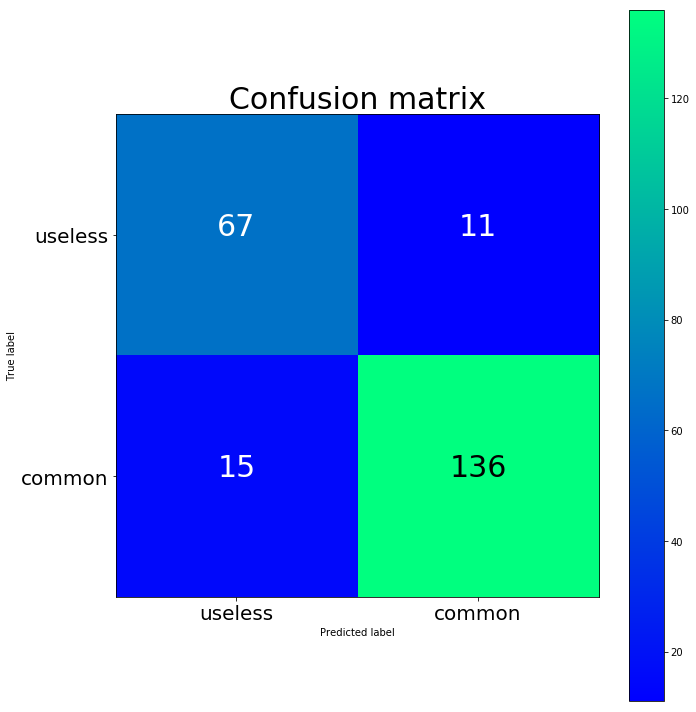

In [17]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['useless','common'], normalize=False, title='Confusion matrix')
plt.show()
# print(cm)

In [18]:
# 混淆矩阵的阅读 查看百度
# 由上图可得模型是 漏判 问题, 错判为0

In [19]:
# 获取 逻辑回归的系数和词典 词个数相同。系数越大，代表给词权重越大
def get_most_important_features(vectorizer, model, n=5):
    # vectorizer 是 sklearn.feature_extraction.text.CountVectorizer 对象
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

In [20]:
importance[0]

{'bottom': [(-1.9233468753654832, '想玩过'),
  (-1.9699934849413354, '东西'),
  (-1.9936101307589726, '一科'),
  (-2.0586707932196653, '完整版'),
  (-2.2143741219571784, '第六感'),
  (-2.2944339277405317, '平台'),
  (-2.296290346516122, '张立根'),
  (-2.5400863161740292, '全过'),
  (-2.6306392117308213, 'f2'),
  (-3.1548797624472003, 'cnm')],
 'tops': [(2.1516471108530144, 'lajibamxigyegei'),
  (2.1803090306315083, '界面'),
  (2.211154149794893, '根本'),
  (2.2950592487795909, '下载'),
  (2.507806444700754, '广告'),
  (2.513095684570573, '不错'),
  (2.8654346669109865, '好难'),
  (2.9219171750081423, '样儿'),
  (3.092310924958777, '老是'),
  (3.2120104179278735, '不能')]}

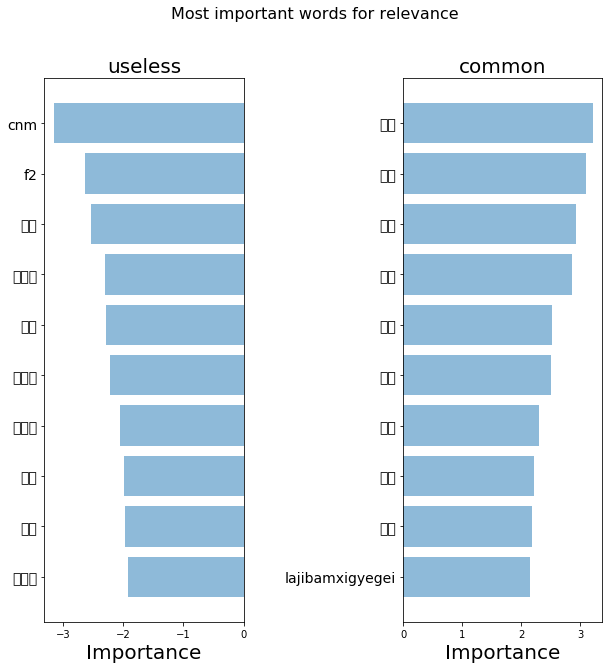

In [21]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('useless', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('common', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [22]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

min x:-3.02791925882e-09, max x:0.746021068178
min y:-0.175363138076, max y:0.921014086479


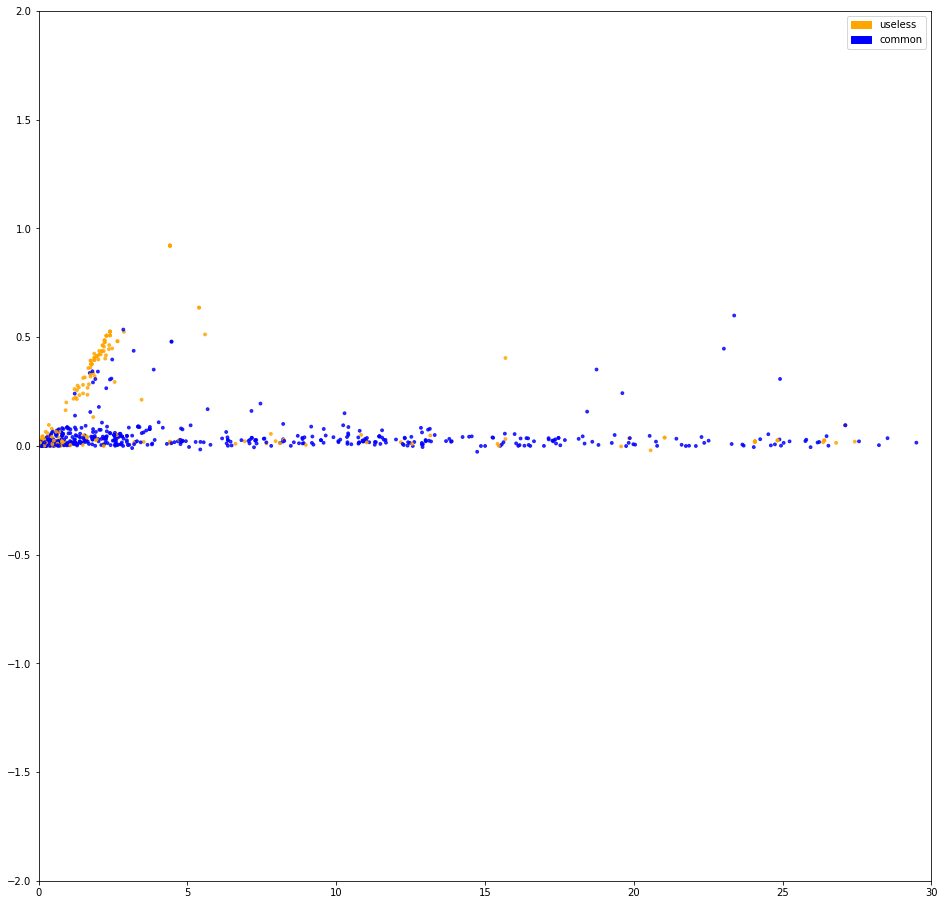

In [23]:
fig = plt.figure(figsize=(16, 16))  
plt.axis([0,30,-2,2]) 
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [24]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [25]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.886, precision = 0.887, recall = 0.886, f1 = 0.887


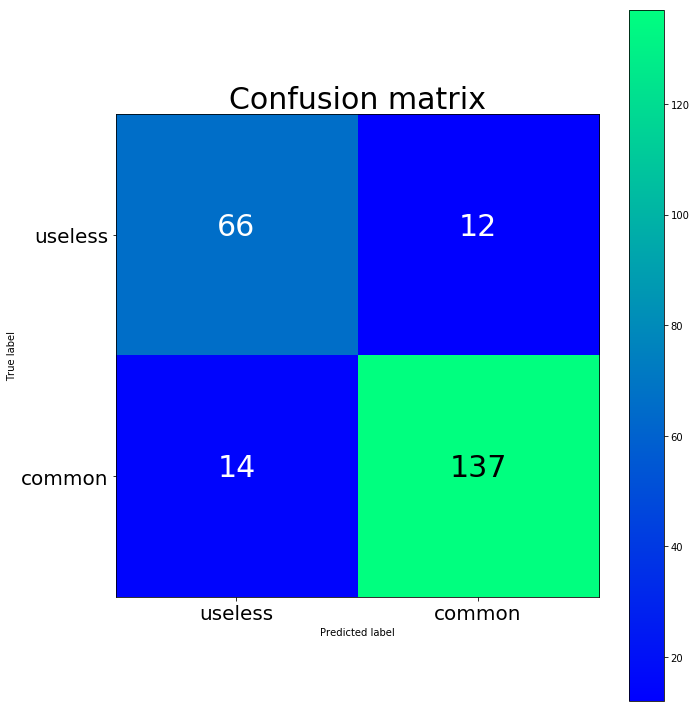

TFIDF confusion matrix
[[ 66  12]
 [ 14 137]]
BoW confusion matrix
[[ 67  11]
 [ 15 136]]


In [26]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['useless','common'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [27]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)
importance_tfidf[0]

{'bottom': [(-2.214806650606687, '完整版'),
  (-2.2968718774370003, '平台'),
  (-2.3906277130396494, '25'),
  (-2.5190525360319769, '东西'),
  (-2.5285441951207162, '张立根'),
  (-2.5486040537728112, '第六感'),
  (-2.5690698501328586, '全过'),
  (-2.9121577550201523, 'f2'),
  (-2.9606557249621637, 'cnm'),
  (-3.0555485879995237, '怎么')],
 'tops': [(2.8541240993039523, '界面'),
  (2.9206942310168413, '可以'),
  (2.9828328519493703, '样儿'),
  (3.2951901279469049, '好难'),
  (3.3947341973882685, '根本'),
  (3.6632320779813283, '不过'),
  (3.7526607158843639, '下载'),
  (3.7721366851475926, '不错'),
  (4.0426384252248146, '广告'),
  (4.0993815170005261, '不能')]}

In [28]:
from gensim.models import KeyedVectors
word2vec_path = "qq_comments_vector"
word2vec = KeyedVectors.load(word2vec_path, mmap='r')

In [29]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=100):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    # print(length)
    # print(vectorized)
    # vectorized = [[1,2,3......100],[1,2,3,.....100],......[1,2,3.......100]] 一个句子n词语，就有 n行
    # np.sum(vectorized, axis=0) 每列相加， 即使每个句子的词个数不同，这样处理，最终都是（1,100）向量
    # 但是必须求平均值，否则肯定不公平，这样就把一个句子 doc2vec 表示出来了
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [30]:
def get_tokens(x):
    return [i for i in x.split(' ')]

In [31]:
# a = [[1,2,3],[2,3,4]]
# np.sum(a, axis=0)
# av = np.divide(b, 2)
# av

In [32]:
df_comment['tokens'] = df_comment['jieba_word'].apply(get_tokens)
# get_word2vec_embeddings 句子由n个词组成，每个词有（1,100）向量组成，
# 注意 100，要和 word2vec 训练库的参数一样，就是约定把，每个词表示成一个（1,100）的向量
embeddings = get_word2vec_embeddings(word2vec, df_comment)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

min x:-0.84088147382, max x:11.1237220542
min y:-10.6047643796, max y:12.6548173101


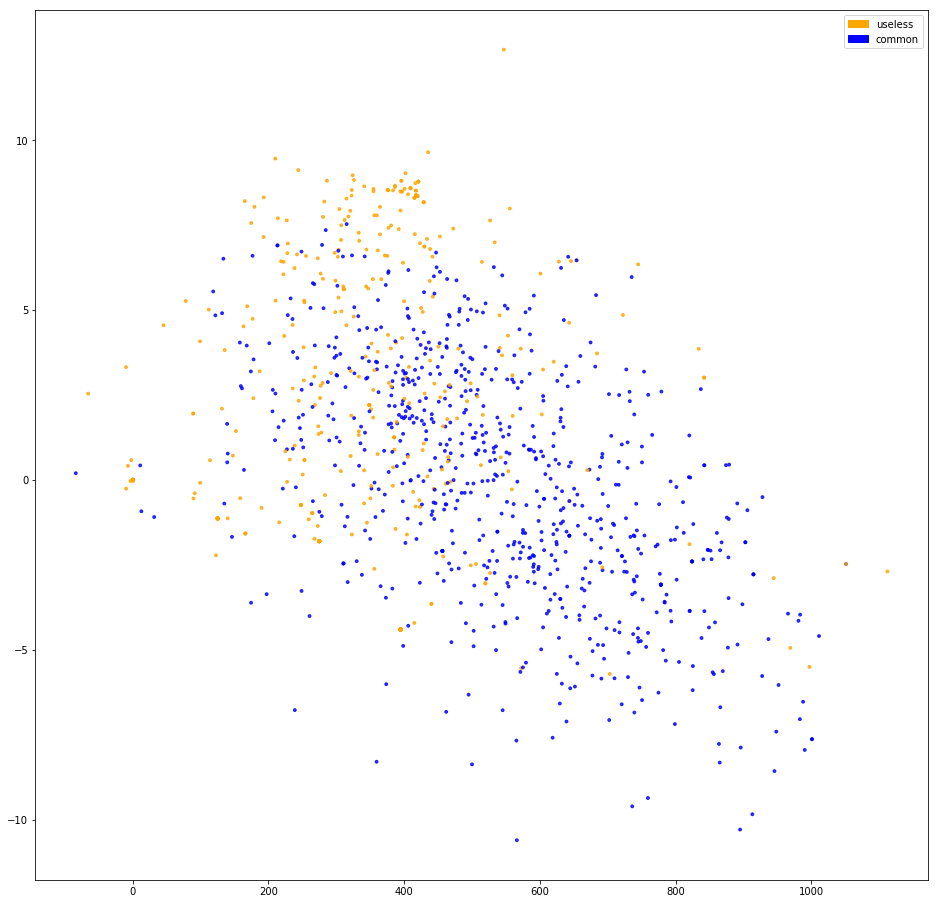

In [33]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

In [34]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [35]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.860, precision = 0.859, recall = 0.860, f1 = 0.858


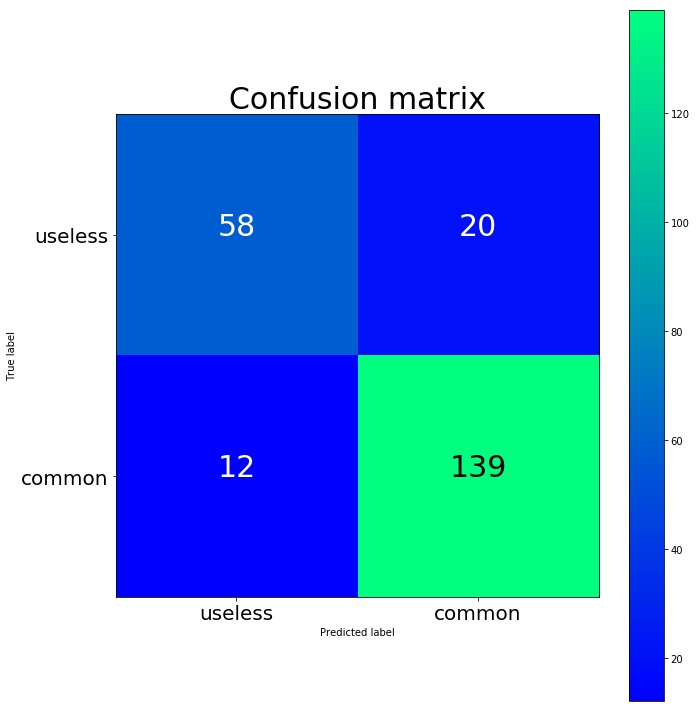

Word2Vec confusion matrix
[[ 58  20]
 [ 12 139]]
TFIDF confusion matrix
[[ 66  12]
 [ 14 137]]
BoW confusion matrix
[[ 67  11]
 [ 15 136]]


In [36]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_w2v, classes=['useless','common'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [37]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# embedding 维度
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = max(df_comment['tokens'].apply(len))
# 要统计总词汇量
from gensim import corpora
words = [x for x in df_comment['tokens']]
dic = corpora.Dictionary(words)
VOCAB_SIZE = len(dic)

VALIDATION_SPLIT=0.2
# num_words 是保留的最大词汇数
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(df_comment['jieba_word'].tolist())
sequences = tokenizer.texts_to_sequences(df_comment['jieba_word'].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# 将 sequence 列表的列表 变成 2d矩阵 numpy shape = (样本数，默认为max的句子词数) 
cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
# cnn_data = pad_sequences(sequences)
labels = to_categorical(np.asarray(df_comment['type']))

indices = np.arange(cnn_data.shape[0])
# 随机排序 shuffle
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
# cnn_data 是shape=(样本数目，每条文本词汇对应字典的序号) 且列数统一补充为最长句子的长度

num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Using TensorFlow backend.


Found 2195 unique tokens.
(2196, 100)


In [38]:
to_categorical([1,0,3,0])

array([[ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.]])

In [39]:
# print(df_comment['jieba_word'][0])
# print(word_index['的'])
# sequences[0]
# np.random.shuffle(np.asarray([0,1,2]))
# int(23.3)
# np.zeros((1,2))
# print(df_comment['type'].unique())
len(word_index)

2195

In [51]:
from keras.layers import Dense, Input, Flatten, Dropout, Merge
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model
# embeddings 是每个词的向量形式构成的矩阵， 
# embedding_dim 是word2vec 每个词向量的维数
# num_words 为什么要+1
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)
    print("num_words:",num_words)
    print("embedding_dim:",embedding_dim)   
    print("input_length：",max_sequence_length)
    print(embedding_layer)
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    
    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]
    # 下面应用了大量的函数式编程
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        print(filter_size,":",l_conv)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Merge(mode='concat', concat_axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    # 编译
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [52]:
# 取样本比例0.8为训练集，0.2为测试集 
# 注意 CNN 的输出是一个 向量了，不是
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]
# +1 是因为 
model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(df_comment['type'].unique())), False)

num_words: 2196
embedding_dim: 100
input_length： 65
3 : Tensor("conv1d_9/Relu:0", shape=(?, 63, 128), dtype=float32)
4 : Tensor("conv1d_10/Relu:0", shape=(?, 62, 128), dtype=float32)
5 : Tensor("conv1d_11/Relu:0", shape=(?, 61, 128), dtype=float32)


/home/mingchao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [47]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Train on 916 samples, validate on 228 samples
Epoch 1/3
916/916 [==============================] - 0s 57us/step - loss: 0.1688 - acc: 0.9334 - val_loss: 0.2489 - val_acc: 0.8640
Epoch 2/3
916/916 [==============================] - 0s 58us/step - loss: 0.1379 - acc: 0.9552 - val_loss: 0.2334 - val_acc: 0.8816
Epoch 3/3
916/916 [==============================] - 0s 66us/step - loss: 0.1087 - acc: 0.9607 - val_loss: 0.2545 - val_acc: 0.8728


In [53]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 65)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 65, 100)      219600      input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 63, 128)      38528       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 62, 128)      51328       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_11 